In [7]:
import numpy as np
import pandas as pd
from sklearn import datasets, tree, ensemble
from sklearn.model_selection import cross_val_score

In [5]:
X = datasets.load_digits().data
y = datasets.load_digits().target
print(X.shape, y.shape)

(1797, 64) (1797,)


Бэггинг – технология классификации, где в отличие от бустинга все элементарные классификаторы обучаются и работают параллельно (независимо друг от друга). Идея заключается в том, что классификаторы не исправляют ошибки друг друга, а компенсируют их при голосовании. Базовые классификаторы должны быть независимыми, это могут быть классификаторы основанные на разных группах методов или же обученные на независимых наборах данных.

In [8]:
DTC = tree.DecisionTreeClassifier()
cross_val_score(DTC, X, y, n_jobs=6, cv = 10, scoring='precision_macro').mean()
#DecisionTreeClassifier

0.8356243243059369

In [10]:
%%time
BC = ensemble.BaggingClassifier(base_estimator = DTC, n_estimators=100)# базовое дерево передали. число деревьев - 100. 
print(cross_val_score(BC, X, y, n_jobs=6, cv = 10, scoring='precision_macro').mean())
#max_feat в дереве - при каждом разбиении

0.9273135634463202
Wall time: 4.04 s


4) При большом количестве признаков (для данного датасета - 40, 50) качество классификации становится хуже, чем при малом количестве признаков (5, 10). Это связано с тем, что чем меньше признаков выбирается в каждом узле, тем более различными получаются деревья (ведь деревья сильно неустойчивы к изменениям в обучающей выборке), и тем лучше работает их композиция.

In [12]:
BC = ensemble.BaggingClassifier(base_estimator = DTC, 
                                n_estimators=100, max_features = int(pow(X.shape[1], 0.5)))
cross_val_score(BC, X, y, n_jobs=-1, cv = 10, scoring='precision_macro').mean()
#бэггинг над DecisionTreeClassifier; 100 деревьев; макс фичей огр у каждого базового алгоритма;случ признаки
#max_features в BaggingClassifier - макс фич у каждого алгоритма(дерева)

0.932786098265564

In [17]:
BC = ensemble.BaggingClassifier(base_estimator = DTC, 
                                n_estimators=100, max_features = int(pow(X.shape[1], 0.5)), max_samples= 0.7)
cross_val_score(BC, X, y, n_jobs=-1, cv = 10, scoring='precision_macro').mean()
#бэггинг над DecisionTreeClassifier; 100 деревьев; макс фичей огр у каждого базового алгоритма;случ признаки
#max_features в BaggingClassifier - макс фич у каждого алгоритма(дерева)

0.9370241668096192

In [13]:
# Наконец, попробуем выбрать случайные признаки не один раз на все дерево, а при построении каждой вершины дерева

In [19]:
BC = ensemble.BaggingClassifier(base_estimator = tree.DecisionTreeClassifier
                                (max_features = int(pow(X.shape[1], 0.5))), 
                                n_estimators=100)
cross_val_score(BC, X, y, n_jobs=-1, cv = 10, scoring='precision_macro').mean()
#бэггинг над рандомизированными деревьями; 100 деревьев; макс фичей огр у каждой вершины дерева

#бэггинг на рандомизированных деревьях (в которых при построении каждой вершины
#выбирается случайное подмножество признаков и разбиение ищется только по ним).
#Это в точности соответствует алгоритму Random Forest

0.9518898403685723

In [20]:
RF = ensemble.RandomForestClassifier(max_depth=20,
    n_estimators=100, max_features=int(pow(X.shape[1], 0.5)))
cross_val_score(RF, X, y, n_jobs=-1, cv = 10, scoring='precision_macro').mean()
#max_feat в RF - при каждом разбиении

0.9521082937959873

7) При небольшой максимальной глубине деревьев (5-6) качество работы случайного леса заметно хуже, чем без ограничений, т.к. деревья получаются недообученными. С ростом глубины качество сначала улучшается, а затем не меняется существенно, т.к. из-за усреднения прогнозов и различий деревьев их переобученность в бэггинге не сказывается на итоговом качестве (все деревья преобучены по-разному, и при усреднении они компенсируют переобученность друг-друга).

In [31]:
from sklearn.model_selection import GridSearchCV
params = {'max_depth':[1,2,3,5,8,10, 13, 17, 20, 25, 30]}
clf = ensemble.RandomForestClassifier(n_estimators=100, max_features=int(pow(X.shape[1], 0.5)))
optimizer = GridSearchCV(estimator=clf, param_grid=params)
optimizer.fit(X, y)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=8,
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              random_

In [68]:
md = optimizer.cv_results_['params']
score = optimizer.cv_results_['mean_test_score']
md = list(map(lambda x: x['max_depth'], md))

Populating the interactive namespace from numpy and matplotlib


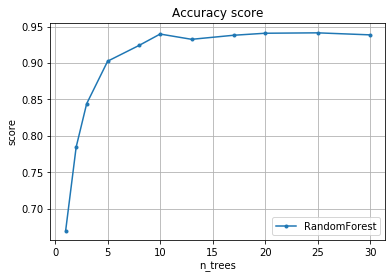

In [69]:
import matplotlib.pyplot as plt

%pylab inline
pylab.plot(md, score, marker='.', label='RandomForest')
pylab.grid(True)
pylab.xlabel('n_trees')
pylab.ylabel('score')
pylab.title('Accuracy score')
pylab.legend(loc='lower right')